# Applying Convolutional Neural Networks to Cryptography for Encryption/Decryption

## By Ria Cheruvu

To tackle the issue of secure communication, I employed Convolutional Neural Networks (CNNs) for the encryption/decryption (128-bit key) and signing/verification functions. 

The following ipynb contains the parameter initialization, variable declaration, weight definition, model definition, user input, training, testing, and performance benchmarking against Fernet for encryption/decryption functions. 

The code is self-explanatory. To run the code, please run the cells in the TensorFlow framework one at a time.

Please Note: User input is mandatory to achieve results. 

I ran the following code through Docker on a Windows 10 Machine with 16 GB RAM and 8-core 3.1 GHz CPU with hyper-threading.

Import the required packages

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import socket
import sys
import pickle


## Parameter Initialization 

The hyperparameters we are using to tune/experiment with the algorithm

In [2]:
crypto_msg_len = N = 16
crypto_key_len = 16
batch_size = 512
epochs = 50
learning_rate = 0.0008 #Optimizer learning rate

# Function to generate n random messages and keys
def gen_data(n=batch_size, msg_len=crypto_msg_len, key_len=crypto_key_len):
    #return (np.random.randint(0, 2, size=(n, msg_len))*2-1), (np.random.randint(0, 2, size=(n, key_len))*2-1)
    return (np.random.randint(0, 2, size=(n, msg_len))), (np.random.randint(0, 2, size=(n, key_len)))




In [3]:
def conv1d(input_, filter_shape, stride, name="conv1d"):
    with tf.variable_scope(name):
        w = tf.get_variable('w', shape=filter_shape, initializer=tf.contrib.layers.xavier_initializer())
        conv = tf.nn.conv1d(input_, w, stride, padding='SAME')
        return conv

## Neural Cryptography Model definition

The implementation of “secure communication” can be described as follows: Generation of the key, the encryption/decryption algorithm, sending the message (platform). An example scenario is as follows: The goal is for Alice to send a message to Bob, and Eve, a party trying to hack into Alice and Bob’s communication, to be unable to read the message. Alice takes a message (plain text) and uses the key she shares with Bob to encrypt plain text into cipher text. This cipher text is sent to Bob, who consumes the communication and key, and decrypts the cipher text into plain text. Eve intercepts the communication of the cipher text, and attempts to recover the plaintext with no knowledge of the keys and in some cases, the encryption algorithm.

To create the original algorithm, I modified adopted code from Liam Schoneveld and GitHub user ankeshanand  to include the convolutional layers and experimented with the parameters by changing the learning rate of the optimizer, the epochs for training and testing, the initial weights, etc. I used the TensorFlow framework and abandoned implementation with the Theano framework, due to lack of CPU optimization libraries on Windows 10; NCA has been implemented in Theano, TensorFlow, and regular python framework by different authors, however, the base algorithm remains the same. I ran the following code through Docker on a Windows 10 Machine with 16 GB RAM and 8-core 3.1 GHz CPU with hyper-threading.

I experimented with the Adam optimizer, Adagrad optimizer, and Momentum optimizer, which use the loss functions for minimizing error. Next, I designed the UI accompanying the NCA algorithm. The user can enter input in ASCII, which is then converted to binary and structured appropriately in order to be accepted by np.array for both encryption/decryption and signing/verification functions.

For socket communication, the user (Alice) types in a plaintext message, which is then encrypted (cipher text) and sent to Bob’s socket. Upon receiving the cipher text, Bob’s shared key is used to decrypt the message and Bob prints out the recovered message.

### Adopted from <cite>"Learning to Protect Communications with Adversarial Neural Cryptography" by Abadi, M & Andersen, D.</cite><br/><cite>https://nlml.github.io/neural-networks/adversarial-neural-cryptography/</cite><br/><cite> https://github.com/ankeshanand/neural-cryptography-tensorflow</cite> 

In [4]:
# Placeholder variables for Message and Key
msg = tf.placeholder("float", [None, crypto_msg_len])
key = tf.placeholder("float", [None, crypto_key_len])

# Weights for fully connected layers
w_alice = tf.get_variable("alice_w", shape=[2 * N, 2 * N], initializer=tf.contrib.layers.xavier_initializer())
w_bob = tf.get_variable("bob_w", shape=[2 * N, 2 * N], initializer=tf.contrib.layers.xavier_initializer())
w_eve1 = tf.get_variable("eve_w1", shape=[N, 2 * N], initializer=tf.contrib.layers.xavier_initializer())
w_eve2 = tf.get_variable("eve_w2", shape=[2 * N, 2 * N], initializer=tf.contrib.layers.xavier_initializer())

# Alice's Machine Network
# FC layer -> Conv Layer (4 1-D convolutions)
alice_input = tf.concat(concat_dim=1, values=[msg, key])
alice_hidden = tf.nn.sigmoid(tf.matmul(alice_input, w_alice))
alice_hidden = tf.expand_dims(alice_hidden, 2)

h0 = tf.nn.relu(conv1d(alice_hidden, [4,1,2], stride=1, name="alice"+'_h0_conv'))
h1 = tf.nn.relu(conv1d(h0, [2,2,4], stride=2, name="alice"+'_h1_conv'))
h2 = tf.nn.relu(conv1d(h1, [1,4,4], stride=1, name="alice"+'_h2_conv'))
h3 = tf.nn.tanh(conv1d(h2, [1,4,1], stride=1, name="alice"+'_h3_conv'))
alice_output = tf.squeeze(h3) # eliminate dimensions of size 1 from the shape of a tensor

# Bob's Machine Network (gets the output (cipher text) of Alice's network)
# FC layer -> Conv Layer (4 1-D convolutions)
bob_input = tf.concat(concat_dim=1, values=[alice_output, key])
bob_hidden = tf.nn.sigmoid(tf.matmul(bob_input, w_bob))
bob_hidden = tf.expand_dims(bob_hidden, 2)

h0 = tf.nn.relu(conv1d(bob_hidden, [4,1,2], stride=1, name="bob"+'_h0_conv'))
h1 = tf.nn.relu(conv1d(h0, [2,2,4], stride=2, name="bob"+'_h1_conv'))
h2 = tf.nn.relu(conv1d(h1, [1,4,4], stride=1, name="bob"+'_h2_conv'))
h3 = tf.nn.tanh(conv1d(h2, [1,4,1], stride=1, name="bob"+'_h3_conv'))
bob_output = tf.squeeze(h3) # eliminate dimensions of size 1 from the shape of a tensor

# Eve's Machine Network
# FC layer -> FC layer -> Conv Layer (4 1-D convolutions)
eve_input = alice_output
eve_hidden1 = tf.nn.sigmoid(tf.matmul(eve_input, w_eve1))
eve_hidden2 = tf.nn.sigmoid(tf.matmul(eve_hidden1, w_eve2))
eve_hidden2 = tf.expand_dims(eve_hidden2, 2)

h0 = tf.nn.relu(conv1d(eve_hidden2, [4,1,2], stride=1, name="eve"+'_h0_conv'))
h1 = tf.nn.relu(conv1d(h0, [2,2,4], stride=2, name="eve"+'_h1_conv'))
h2 = tf.nn.relu(conv1d(h1, [1,4,4], stride=1, name="eve"+'_h2_conv'))
h3 = tf.nn.tanh(conv1d(h2, [1,4,1], stride=1, name="eve"+'_h3_conv'))
eve_output = tf.squeeze(h3)


## Neural Cryptography Training

In [5]:
alice_errors, bob_errors, eve_errors = [], [], []

# Loss Functions
decrypt_err_eve = tf.reduce_mean(tf.abs(msg - eve_output))
decrypt_err_alice = tf.reduce_mean(tf.abs(msg - alice_output))
loss_alice = decrypt_err_alice + (1. - decrypt_err_eve) ** 2.
decrypt_err_bob = tf.reduce_mean(tf.abs(msg - bob_output))
loss_bob = decrypt_err_bob + (1. - decrypt_err_eve) ** 2.

# Get training variables corresponding to each network
t_vars = tf.trainable_variables()
alice_vars = [var for var in t_vars if 'alice_' in var.name]
bob_vars =   [var for var in t_vars if 'bob_' in var.name]
eve_vars =   [var for var in t_vars if 'eve_' in var.name]

# Build the optimizers, can play with different optimizers

'''
alice_optimizer = tf.train.AdagradOptimizer(learning_rate, initial_accumulator_value=0.1, 
                       use_locking=False, name='Adagrad').minimize(loss_alice, var_list=alice_vars)
bob_optimizer = tf.train.AdagradOptimizer(learning_rate, initial_accumulator_value=0.1, 
                        use_locking=False, name='Adagrad').minimize(loss_bob, var_list=bob_vars)
eve_optimizer = tf.train.AdagradOptimizer(learning_rate, initial_accumulator_value=0.1, 
                        use_locking=False, name='Adagrad').minimize(decrypt_err_eve, var_list=eve_vars)

alice_optimizer = tf.train.MomentumOptimizer(0.01, 0.9).minimize(loss_alice, var_list=alice_vars)   
bob_optimizer = tf.train.MomentumOptimizer(0.01, 0.9).minimize(loss_bob, var_list=bob_vars)
eve_optimizer = tf.train.MomentumOptimizer(0.01, 0.9).minimize(decrypt_err_eve, var_list=eve_vars)

'''
alice_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_alice, var_list=alice_vars)   
bob_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_bob, var_list=bob_vars)
eve_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(decrypt_err_eve, var_list=eve_vars)

def train(sess):
    # Begin Training
    tf.initialize_all_variables().run(session=sess)
    for i in range(epochs):
        iterations = 2000

        alice_loss, _, _ = _train('alice', iterations, sess)
        alice_errors.append(alice_loss)
        print( 'Training Alice, Epoch:', i + 1, ' error: ', alice_loss)

        _, bob_loss, _ = _train('bob', iterations, sess)
        bob_errors.append(bob_loss)
        print( 'Training Bob, Epoch:', i + 1, ' error: ', bob_loss)

        _, _, eve_loss = _train('eve', iterations, sess)
        eve_errors.append(eve_loss)   
        print( 'Training Eve, Epoch:', i + 1, ' error: ', eve_loss)


def _train(network, iterations, sess):
    alice_decrypt_error, bob_decrypt_error, eve_decrypt_error = 1., 1., 1.

    bs = batch_size
    # Train Eve for two minibatches to give it a slight computational edge
    if network == 'eve':
        bs *= 2

    for i in range(iterations):
        msg_in_val, key_val = gen_data(n=bs, msg_len=crypto_msg_len, key_len=crypto_key_len)
        feed_dict={msg: msg_in_val, key: key_val}
        if network == 'alice':
            _, decrypt_err = sess.run([alice_optimizer, decrypt_err_alice], feed_dict = feed_dict)
            alice_decrypt_error = min(alice_decrypt_error, decrypt_err)
        elif network == 'bob':
            _, decrypt_err = sess.run([bob_optimizer, decrypt_err_bob], feed_dict = feed_dict)
            bob_decrypt_error = min(bob_decrypt_error, decrypt_err)
        elif network == 'eve':
            _, decrypt_err = sess.run([eve_optimizer, decrypt_err_eve], feed_dict = feed_dict)
            eve_decrypt_error = min(eve_decrypt_error, decrypt_err)

    return alice_decrypt_error, bob_decrypt_error, eve_decrypt_error

## Neural Cryptography Testing Helper Functions

This section of the code takes input and prepares it for the socket communication

In [6]:
text = input('Enter some text: ')
bintext = ' '.join('{0:08b}'.format(ord(x), 'b') for x in text)
print (bintext)
b1  = bintext.replace(" ", "")
#b1 = b1.zfill(48)
pad = len(b1)%16

v1 = np.array([])
for i in range(0, len(b1)):
    v1 = np.append(v1, int(b1[i]))

#apply the padding
for i in range(0, pad):
    v1 = np.append(v1, int(0))
total_len = len(b1) + pad

plaintext_to_Alice = v1.reshape(int(total_len/16), 16)
print('plaintext_to_Alice = ', plaintext_to_Alice)

Enter some text: abc
01100001 01100010 01100011
plaintext_to_Alice =  [[ 0.  1.  1.  0.  0.  0.  0.  1.  0.  1.  1.  0.  0.  0.  1.  0.]
 [ 0.  1.  1.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


## Socket Communication

The user (Alice) inputs a message to send to Bob's socket

In [7]:
def sock_send(message):
    # Create a TCP/IP socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server_address = ('localhost', 10000)
    sock.connect(server_address)
    #To send data over network, you need to serialize it into an array of bytes,
    #then deserialize it back. In Python, serialization of most objects can be done via pickle module:
    print('message = ', message)
    msg2 = pickle.dumps(message)
    #print('msg2 = ', msg2)
    sock.send(msg2)

In [8]:
def sock_recv_init():
    # Create a TCP/IP socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    # Bind the socket to the port
    address = ('localhost', 10000)
    print('starting up on %s port %s' % address)
    sock.bind(address)
    # Listen for incoming connections
    sock.listen(1)
    return sock

def sock_recv(sock):
    # Wait for a connection
    print( 'waiting for a connection')
    connection, client_address = sock.accept()
    print('connection from', client_address)
    # Receive the data (max 48 bytes)
    data = connection.recv(1024*10)
    #print('received "%s"' % data)
    data1 = pickle.loads(data)
    print('received ', data1)
    return data1

sock = sock_recv_init()

starting up on localhost port 10000


In [9]:
test_file_msg = "testmsg.txt"
test_file_keys = "testkey.txt"

def test(network, sess):
        alice_decrypt_error, bob_decrypt_error, eve_decrypt_error = 1., 1., 1.
        alice_encrypt_time = 0
        bob_decrypt_time = 0
        bob_output_1 = 0
        
        #bs = 3 #batch_size
        bs = int(total_len/16) #batch_size
        messages, keys = gen_data(n=bs, msg_len=crypto_msg_len, key_len=crypto_key_len)
        #test message to get the code complete
        messages = np.array([
                    [1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1], 
                    [0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1],
                    [1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1]
                   ])


        #feed_dict={msg: messages, key: keys}
        feed_dict={msg: plaintext_to_Alice, key: keys}

        print( 'messages = \n', plaintext_to_Alice)
        print( 'keys = \n', keys)

        if network == 'alice':
            print('plaintext_to_Alice = ', plaintext_to_Alice)
            start_time = time.time()
            _, decrypt_err, alice_output_1  = sess.run([alice_optimizer, decrypt_err_alice, alice_output], feed_dict = feed_dict)
            end_time = time.time()
            alice_encrypt_time = end_time-start_time
            print('test alice_output (***Cipher Text***) = \n', alice_output_1)       
            alice_decrypt_error = min(alice_decrypt_error, decrypt_err)
            print('SOCK_SEND')
            sock_send(alice_output_1)
        elif network == 'bob':
            print('SOCKET_RECV ==== \n')
            messages_sock = sock_recv(sock)
            print(messages_sock)
            feed_dict1 = {msg: messages_sock, key: keys}
            start_time = time.time()
            _, decrypt_err, bob_input_1, bob_output_1 = sess.run([bob_optimizer, decrypt_err_bob, bob_input, bob_output], feed_dict = feed_dict1)
            end_time = time.time()
            bob_decrypt_time = end_time-start_time
            bob_input_1 = np.round(bob_input_1, 2)
            bob_ouput_1 = np.round(bob_output_1, 2)
            
            print('test bob_input (***Cipher Text***) = \n', bob_input_1, 2)       
            print('test bob_output (***Plain Text***)= \n',  bob_output_1, 2)       
            bob_decrypt_error = min(bob_decrypt_error, decrypt_err)
        elif network == 'eve':
            _, decrypt_err = sess.run([eve_optimizer, decrypt_err_eve], feed_dict = feed_dict)
            eve_decrypt_error = min(eve_decrypt_error, decrypt_err)

        return alice_decrypt_error, alice_encrypt_time, bob_decrypt_error, bob_decrypt_time, bob_output_1, eve_decrypt_error

The following code is the plot helper function. The plots demonstrate the decryption errors of the three parties per epoch when training the CNN and illustrate whether Eve was able to converge with Alice and Bob.  

In [10]:
%matplotlib inline

def plot_results():
    """
    Plot Lowest Decryption Errors achieved by Alice, Bob, and Eve per epoch
    """
    sns.set_style("darkgrid")
    plt.plot(alice_errors)
    plt.plot(bob_errors)
    plt.plot(eve_errors)
    plt.legend(['alice', 'bob', 'eve'])
    plt.xlabel('Epoch')
    plt.ylabel('Lowest Decryption error achieved')
    plt.show()

# TensorFlow Session 

## Training

Starting Training Process... 
Training Alice, Epoch: 1  error:  0.0280805
Training Bob, Epoch: 1  error:  0.0281553
Training Eve, Epoch: 1  error:  0.487395
Training Alice, Epoch: 2  error:  0.0276304
Training Bob, Epoch: 2  error:  0.0267888
Training Eve, Epoch: 2  error:  0.485718
Training Alice, Epoch: 3  error:  0.0263653
Training Bob, Epoch: 3  error:  0.0277089
Training Eve, Epoch: 3  error:  0.484802
Training Alice, Epoch: 4  error:  0.0267609
Training Bob, Epoch: 4  error:  0.0266388
Training Eve, Epoch: 4  error:  0.486938
Training Alice, Epoch: 5  error:  0.026745
Training Bob, Epoch: 5  error:  0.0270468
Training Eve, Epoch: 5  error:  0.487122
Training Alice, Epoch: 6  error:  0.0264922
Training Bob, Epoch: 6  error:  0.0276856
Training Eve, Epoch: 6  error:  0.487122
Training Alice, Epoch: 7  error:  0.0273449
Training Bob, Epoch: 7  error:  0.0267432
Training Eve, Epoch: 7  error:  0.486572
Training Alice, Epoch: 8  error:  0.0263675
Training Bob, Epoch: 8  error:  0.0265

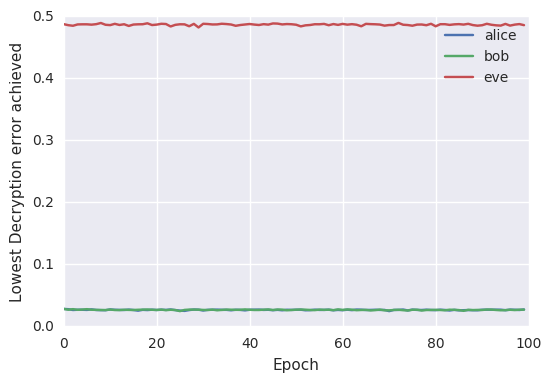

alice_errors_train =  [0.028080454, 0.027630437, 0.02636526, 0.026760923, 0.026745038, 0.026492171, 0.027344916, 0.026367491, 0.026123162, 0.026001001, 0.027221691, 0.0267334, 0.026489258, 0.026367188, 0.026977539, 0.026367188, 0.025268573, 0.026611343, 0.026245119, 0.026855469, 0.026367188, 0.026855469, 0.026489258, 0.02722168, 0.026245117, 0.025390625, 0.024902344, 0.026245117, 0.027099609, 0.026855469, 0.025512695, 0.026611328, 0.026733398, 0.026977539, 0.026611328, 0.026611328, 0.025878906, 0.026733398, 0.026489258, 0.025756836, 0.026733398, 0.026855469, 0.026977539, 0.026489258, 0.026733398, 0.026001301, 0.02661133, 0.025878906, 0.026733398, 0.026489258, 0.026733398, 0.026855469, 0.025878906, 0.026123047, 0.026855469, 0.026489258, 0.026489258, 0.026855469, 0.025878906, 0.026489258, 0.026000977, 0.026855469, 0.026123047, 0.027099609, 0.026855469, 0.026367188, 0.026489258, 0.026733398, 0.026489258, 0.026489258, 0.024536133, 0.026489258, 0.026489258, 0.027099609, 0.025634766, 0.02697

In [11]:
import time
epochs = 100
#sess = tf.InteractiveSession()
sess = tf.Session()

#with tf.Session() as sess:
print('Starting Training Process... ')
start_time = time.time()
train(sess)
end_time = time.time()
print('Time taken for Training (seconds): ', end_time-start_time)
plot_results()

print('alice_errors_train = ', alice_errors)
print('bob_errors_train = ', bob_errors)
print('eve_errors_train = ', eve_errors)


## Testing 

The above section of the code for training the CNN does not have to be rerun if the user decides to input another message.

In [12]:
import binascii

#Test the Neural Crypto model
start_time = time.time()
print( 'Testing Alice' )
alice_loss_test, alice_encrypt_time, _, _, _,_ = test('alice', sess)
print('alice_errors_test = ', alice_loss_test)
print( 'Testing Bob' )
_,_, bob_loss_test, bob_decrypt_time, bob_output_1,_ = test('bob', sess)
print('bob_errors_test = ', bob_loss_test)    
print( 'Testing Eve' )
_, _,_,_,_,eve_loss_test = test('eve', sess)
print('eve_errors_test = ', eve_loss_test)
end_time = time.time()
print('Time taken for Testing (seconds): ', end_time-start_time)
#convert to ASCII
b1 = np.round(bob_output_1, 1)
b1 = b1.ravel();
b1 = np.abs(b1)
print('bob_ouput_1 == ', b1)
print('\n')
b2  = np.array2string(b1)
b2 = b2.strip('[')
b2 = b2.strip(']')
b2 = b2.replace(" ", "")
b2 = b2.replace(".", "")
b2 = b2.replace("\n", "")

b2 = '0b'+b2
print('b2 = ', b2)
n = int(b2,2)
str2 = n.to_bytes((n.bit_length() + 7) // 8, 'big').decode(errors='ignore')
print(str2)

print('Bob recovered Plain Text = ', str2)


Testing Alice
messages = 
 [[ 0.  1.  1.  0.  0.  0.  0.  1.  0.  1.  1.  0.  0.  0.  1.  0.]
 [ 0.  1.  1.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]
keys = 
 [[0 1 1 1 1 0 1 1 1 1 0 0 1 0 1 0]
 [0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0]]
plaintext_to_Alice =  [[ 0.  1.  1.  0.  0.  0.  0.  1.  0.  1.  1.  0.  0.  0.  1.  0.]
 [ 0.  1.  1.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]
test alice_output (***Cipher Text***) = 
 [[ 0.  1.  1.  0.  0.  0.  0.  1.  0.  1.  1.  0.  0.  0.  1.  0.]
 [ 0.  1.  1.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]
SOCK_SEND
message =  [[ 0.  1.  1.  0.  0.  0.  0.  1.  0.  1.  1.  0.  0.  0.  1.  0.]
 [ 0.  1.  1.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]
alice_errors_test =  0.0
Testing Bob
messages = 
 [[ 0.  1.  1.  0.  0.  0.  0.  1.  0.  1.  1.  0.  0.  0.  1.  0.]
 [ 0.  1.  1.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]
keys = 
 [[0 0 1 1 0 1 1 1 0 1 0 0 0 1 1 1]
 [0 0 1 1 0 0 1 0 1 1 0 1 0 0 1 1]]
SOC

## Performance Benchmarking with cryptography.fernet

Fernet is an implementation of symmetric encryption. It uses AES for encryption and SHA256 for authentication, with initialization vectors generated using os.urandom(). The following code compares AES to NCA in terms of time.

In [ ]:
#Install the Cryptography module
pip install cryptography

In [13]:
from cryptography.fernet import Fernet
key = Fernet.generate_key()
cipher_suite = Fernet(key)
#Preprocess the array from input block above
v2 = []
for i in range(0, len(b1)):
    v2.append(int(b1[i]))
    
print('Cryptography.fernet AES Encrypt/Decrypt sessions')
print('------------------------------------------------')

start_time = time.time()
cipher_text = cipher_suite.encrypt(bytes(v2))
end_time = time.time()
fernet_encrypt_time = end_time - start_time
print('cipher text = ', cipher_text)

start_time = time.time()
plain_text = cipher_suite.decrypt(cipher_text)
end_time = time.time()
fernet_decrypt_time = end_time - start_time
print('plain_text =  ', plain_text)

print('*********Performance of NCA versus Cryptography.Fernet********************')
print('Time taken for Alice to Encrypt the Plain Text (seconds): ', alice_encrypt_time)
print('Time taken for Bob to Decrypt the Cipher Text (seconds): ', bob_decrypt_time)

print('Time taken for Fernet to Encrypt the Plain Text (seconds): ', fernet_encrypt_time)
print('Time taken for Fernet to Decrypt the Cipher Text (seconds): ', fernet_decrypt_time)


Cryptography.fernet AES Encrypt/Decrypt sessions
------------------------------------------------
cipher text =  b'gAAAAABYUQDSVJIlzaUJQZwA4avRDLdgEvPHI8xEiSTqvXofV5RaP5Cyq10n-_-H4XfYio8E54njBQNKNVzrWfiQYPIRcy5-BsTz8mEvpBi3AMPQ1UitAeU9rUF5JzekFjCohW46qtGq'
plain_text =   b'\x00\x01\x01\x00\x00\x00\x00\x01\x00\x01\x01\x00\x00\x00\x01\x00\x00\x01\x01\x00\x00\x00\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00'
*********Performance of NCA versus Cryptography.Fernet********************
Time taken for Alice to Encrypt the Plain Text (seconds):  0.023770809173583984
Time taken for Bob to Decrypt the Cipher Text (seconds):  0.010978460311889648
Time taken for Fernet to Encrypt the Plain Text (seconds):  0.0004811286926269531
Time taken for Fernet to Decrypt the Cipher Text (seconds):  0.0001995563507080078


# Conclusion

I have demonstrated that it is possible to achieve low error rates multiple times with neural networks, despite the fact that CNNs are not consistent. The communication between Alice and Bob was simulated through sockets to demonstrate a real-life application of the CNNs on a TCP/IP network. There are numerous opportunities for NCA, including the possibility of using NCA for secure communication between autonomous IoT devices. Another opportunity for NCA would be for Artificial Intelligence due to its dynamically self-configurable nature and because it can function efficiently in massively parallel processing environments.


Future Work: The foremost concern is to try and improve the consistency of NCA through further hyperparameter tuning. Future work also includes implementing the sockets over Internet Protocol, instead of localhost. In addition, other goals include implementing Eve and her socket as part of the crypto-pipeline. Tests, such as performance benchmarking, can be performed against AES, SHA-256, and other encryption techniques to assess the strengths and weaknesses of the NCA algorithm for further improvement. 

Another important field that I would like to explore is the combination of quantum and neural cryptography. Quantum cryptography involves altering the contents of a message in transit as soon as the attacker (Eve) sees it; this guarantees the integrity of the message. For example, quantum cryptography could be used as a potential channel for transmission of messages encrypted through NCA.  